In [6]:
import sys
# setting path
sys.path.append('..')

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from src import io, var, utils, fourier, lin_reg, reconstruction
from vis import plotter

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)

importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

In [5]:
grid = var.grid()
cell = var.topo_cell()
    
reader = inout.ncdata()
fn = '../data/icon_grid_0012_R02B04_G_linked.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg)

lat_ref = 43
lon_ref = 42
vid = utils.pick_cell(lat_ref, lon_ref, grid)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

Nx, Ny = 480, 480

cell.lat = np.linspace(lat_v.min(), lat_v.max(), Nx)
cell.lon = np.linspace(lon_v.min(), lon_v.max(), Ny)

cell.gen_mgrids()
cell.topo = np.cos(cell.lon_grid)

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle)

NameError: name 'inout' is not defined

In [ ]:
grid = var.grid()
cell = var.topo_cell()

vid = utils.isoceles(grid, cell)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

cell.gen_mgrids()
cell.topo = np.sin( -3.0 * cell.lat_grid + 1.0 * cell.lon_grid)

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle)

In [ ]:
def get_opt_alpha(fobj, cell, rng, verbose=True, llkk=None):
    errs = np.zeros_like(rng)
    li, ki = llkk
    
    for ii, lmbda in enumerate(rng):
        lmbda = np.around(lmbda, 2)
        a_m, data_recons = lin_reg.do(fobj, cell, lmbda = lmbda)

        fobj.get_freq_grid(a_m)
        freqs = 2.0 * np.abs(fobj.ampls)
        max_frq = freqs.max()
        
        ref = np.zeros_like(freqs)
        ref[li,ki] = 1.0

        if verbose: print(ii, lmbda, max_frq, np.abs(np.linalg.norm(freqs - ref)), freqs.sum())
        errs[ii] = np.abs(np.linalg.norm(freqs - ref))
        # if verbose: print(ii, lmbda, max_frq, np.abs(np.linalg.norm(freqs) - 1.0), freqs.sum())
        # errs[ii] = np.abs(np.linalg.norm(freqs) - 1.0)
            
    if verbose: print("")
    return errs, [data_recons, freqs]

In [ ]:
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)

cl_range = np.arange(1,11) / 10.0
cl_errs, _ = get_opt_alpha(cl_range)
    
print("")

min_cl = cl_range[np.argmin(cl_errs)]
min_err_cl = cl_errs[np.argmin(cl_errs)]

fl_range = np.linspace(min_cl-0.09, min_cl+0.09, 19)
fl_errs, _ = get_opt_alpha(fl_range)

print("")

min_fl = fl_range[np.argmin(fl_errs)]
min_err_fl = fl_errs[np.argmin(fl_errs)]

##### !!! REDO RECONS FOR OPTIMAL ALPHA

err_opt, data_recons = get_opt_alpha([min_fl])

dat_2D = reconstruction.recon_2D(data_recons, cell)
err_dat = np.linalg.norm(dat_2D - cell.topo)

print(err_dat)

## Search for optimal $\alpha$ over all $(k,l)$-pairs

In [ ]:
#### define wavenumber range
nhi = 12
nhj = 12
ll = np.arange(-(nhj/2-1),nhj/2+1)
kk = np.arange(0,nhi)

#### initialise solution arrays
cl_range = np.arange(1,11) / 10.0
fl_range = np.zeros((19))

coarse_lmbdas = np.zeros((nhi,nhj,len(cl_range)))
fine_lmbdas = np.zeros((nhi,nhj,len(fl_range)))

coarse_lmbdas_errs = np.zeros_like(coarse_lmbdas)
fine_lmbdas_errs = np.zeros_like(fine_lmbdas)

min_cls, min_fls = np.zeros((nhi,nhj)), np.zeros((nhi,nhj))
min_errs_cl, min_errs_fl = np.zeros((nhi,nhj)), np.zeros((nhi,nhj))

dat_errs, opt_lmbdas = np.zeros((nhi,nhj)), np.zeros((nhi,nhj))
opt_errs = np.zeros((nhi,nhj))


#### initialise triangle
grid = var.grid()
cell = var.topo_cell()

vid = utils.isoceles(grid, cell)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

cell.gen_mgrids()

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)

# get mask array
mask = triangle.vec_get_mask(cell.lon_grid.ravel(), cell.lat_grid.ravel())
mask = mask.reshape(cell.lon_grid.shape)

#### for each wavenumber pair...

for li,ln in enumerate(ll):
    for ki,kn in enumerate(kk):
        print("(kn,ln) = ", kn, ln)
        
        if ((kn == 0) and (ln < 0)):
            continue
        
        #### generate reference solution in the triangle
        # cell.topo = np.sin( kn * cell.lon_grid + ln * cell.lat_grid)
        cell.topo = np.cos( kn * cell.lon_grid + ln * cell.lat_grid + np.pi)
        triangle = utils.triangle(lon_v, lat_v)
        cell.get_masked(triangle, mask = mask)
        
        fobj = fourier.f_trans(nhi,nhj)
        fobj.do_full(cell)
        
        
        #### search for optimal coarse lambdas
        cl_errs, _ = get_opt_alpha(fobj, cell, cl_range, llkk=[li,ki])
        
        coarse_lmbdas[li,ki,...] = cl_range
        coarse_lmbdas_errs[li,ki,...] = cl_errs

        min_cl = cl_range[np.argmin(cl_errs)]
        min_err_cl = cl_errs[np.argmin(cl_errs)]
        
        min_cls[li,ki] = min_cl
        min_errs_cl[li,ki] = min_err_cl

        
        #### search for optimal fine lambdas
        fl_range[...] = np.linspace(min_cl-0.09, min_cl+0.09, 19)
        fl_errs, _ = get_opt_alpha(fobj, cell, fl_range, llkk=[li,ki])
        
        fine_lmbdas[li,ki,...] = fl_range
        fine_lmbdas_errs[li,ki,...] = fl_errs

        min_fl = fl_range[np.argmin(fl_errs)]
        min_err_fl = fl_errs[np.argmin(fl_errs)]
        
        min_fls[li,ki] = min_fl
        min_errs_fl[li,ki] = min_err_fl

        
        ##### redo recons with the optimal lambda found
        err_opt, data = get_opt_alpha(fobj, cell, [min_fl], llkk=[li,ki])
        data_recons, data_freqs = data

        dat_2D = reconstruction.recon_2D(data_recons, cell)
        err_dat = np.linalg.norm(dat_2D - cell.topo)
        
        # print(err_dat)
        
        opt_errs[li,ki] = err_opt
        opt_lmbdas[li,ki] = min_fl
        dat_errs[li,ki] = err_dat
        
        fs = (10,5)
        fig, axs = plt.subplots(1,2, figsize=fs)
        fig_obj = plotter.fig_obj(fig, nhi, nhj)
        axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
        axs[1] = fig_obj.freq_panel(axs[1], data_freqs)
        plt.show()



Output optimal $\alpha$'s

In [ ]:
writer = io.writer('cos_test_func_l2(freq-1)')
writer.populate('data', 'coarse_lmbdas', coarse_lmbdas)
writer.populate('data', 'fine_lmbdas', fine_lmbdas)
writer.populate('data', 'coarse_errs', coarse_lmbdas_errs)
writer.populate('data', 'fine_errs', fine_lmbdas_errs)

writer.populate('data', 'min_cls', min_cls)
writer.populate('data', 'min_fls', min_fls)

writer.populate('data', 'min_errs_cls', min_errs_cl)
writer.populate('data', 'min_errs_fls', min_errs_fl)

writer.populate('data', 'dat_errs', dat_errs)
writer.populate('data', 'opt_lmbdas', opt_lmbdas)
writer.populate('data', 'opt_errs', opt_errs)

In [ ]:
oec = np.copy(opt_errs)
olb = np.copy(opt_lmbdas)
ode = np.copy(dat_errs)
oec[5,0] = 0.0
olb[5,0] = 0.0
ode[5,0] = 0.0

# print(oec)

In [ ]:
fs = (10,10)
fig, axs = plt.subplots(2,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, nhi, nhj)                              
axs[0,0] = fig_obj.freq_panel(axs[0,0], olb, title="optimal lambdas")
axs[0,1] = fig_obj.freq_panel(axs[0,1], oec, title="error in ampls")
axs[1,0] = fig_obj.freq_panel(axs[1,0], np.log(ode), title="log(L2-error in data)")
plt.show()

## Investigate a single triangle...

In [10]:
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)

#### define wavenumber range
nhi = 12
nhj = 12
ll = np.arange(-(nhj/2-1),nhj/2+1)
kk = np.arange(0,nhi)

#### initialise triangle
grid = var.grid()
cell = var.topo_cell()

vid = utils.isoceles(grid, cell)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

cell.gen_mgrids()

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)

#### generate reference solution in the triangle
kn, ln = 6.0, -1.0
cell.topo = np.sin( kn * cell.lon_grid + ln * cell.lat_grid)

# get mask array
cell.get_masked(triangle)
cell.get_grad_topo(triangle)

AttributeError: 'topo_cell' object has no attribute 'grad_lat_grid'

In [11]:
fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)

am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.0)

fobj.get_freq_grid(am)
dat_2D = reconstruction.recon_2D(data_recons, cell)

freqs = 2.0 * np.abs(fobj.ampls)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, nhi, nhj)                              
axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title="")
axs[1] = fig_obj.freq_panel(axs[1], freqs, title="")
plt.show()

AttributeError: 'topo_cell' object has no attribute 'wlat'

In [ ]:
fobj.set_kls([0],[6])
fobj.do_full(cell)

am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.0)

fobj.get_freq_grid(am)
dat_2D = reconstruction.recon_2D(data_recons, cell)

freqs = 2.0 * np.abs(fobj.ampls)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)                              
axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title="")
axs[1] = fig_obj.freq_panel(axs[1], freqs, title="")
plt.show()

## HDF5 reader routine
Need to move this into core codebase eventually.

In [ ]:
import h5py

path = writer.OUTPUT_FULLPATH + writer.FORMAT
file = h5py.File(path, 'r')

read = file['opt_errs']['opt_errs_data'][:]
file.close()

print(read)

## Study reconstruction via selecting the largest amplitudes

Here, we look at what happens (smeared spectrum) if we do not apply regularisation.

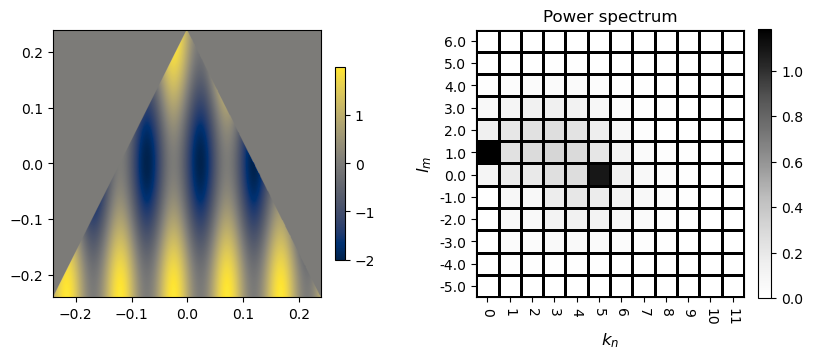

In [12]:
vid = utils.isoceles(grid, cell)

cell.wlat = np.diff(cell.lat).max()
cell.wlon = np.diff(cell.lon).max()

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

cell.gen_mgrids()

cell.topo = np.cos(1.0 * cell.lat_grid) + np.sin(5.0 * cell.lon_grid)# + np.pi
# cell.topo = utils.gen_art_terrain(cell.lat_grid.shape)

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
if hasattr(cell, 'mask'):
    cell.get_masked(triangle, mask=cell.mask)
else:
    cell.get_masked(triangle)

nhi = 12
nhj = 12
fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)
a_m, data_recons = lin_reg.do(fobj, cell)

fobj.get_freq_grid(a_m)
freqs = np.abs(fobj.ampls)

dat_2D = reconstruction.recon_2D(data_recons, cell)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()

In [13]:
np.random.seed(555)

r_row = np.random.randint(0,144-5,size=10)
r_col = np.random.randint(0,144-5-1,size=10)
r_entries = np.random.randint(0,((144-5)*2)-1,size=10)
r_ampl = np.random.random(size=10)


sz = 10
nk = np.random.randint(0,12, size=sz)
nl = np.random.randint(-5,6, size=sz)

for ii  in range(sz):
    if nk[ii] == 0 and nl[ii] < 0:
        nk[ii] += np.random.randint(1,11)
pts = [item for item in zip(nk,nl)]

pts = np.array(list(set(pts)))
print(pts, len(pts))
nk = pts[:,0]
nl = pts[:,1]

sz = len(pts)

Ak = np.random.random(size=sz) * 100.0
Al = np.random.random(size=sz) * 100.0
print(nk, nl)
print(np.sort(Ak)[::-1], Al)

sck = np.random.randint(0,2,size=sz)
scl = np.random.randint(0,2,size=sz)
print(sck, scl)

nhi = 12
nhj = 12
freqs_ref = np.zeros((nhi,nhj))
# freqs_ref[...] = 0.0

cnt = 0
for pt in pts:
    kk, ll = pt
    ll += 5
    print(kk,ll)
    freqs_ref[ll, kk] = Ak[cnt]
            
    cnt += 1
    
ref_sum = freqs_ref.sum()

[[ 2  4]
 [ 8 -1]
 [10  5]
 [ 5 -1]
 [ 3  0]
 [10  0]
 [ 5  3]
 [ 9  1]
 [10  2]
 [ 9  4]] 10
[ 2  8 10  5  3 10  5  9 10  9] [ 4 -1  5 -1  0  0  3  1  2  4]
[72.54933625 72.03739344 59.87266307 57.34133141 45.85460672 28.90634369
 22.71354816 18.11068143  6.11579367  3.77039117] [98.04102031 36.00066307 18.70140567 91.06135221 95.9212662  44.87801652
 72.5613325  75.75834482 16.34046311 47.8318359 ]
[1 0 0 1 1 0 0 0 0 0] [1 1 1 1 0 0 0 1 1 0]
2 9
8 4
10 10
5 4
3 5
10 5
5 8
9 6
10 7
9 9


Regenerate the nice triangle...

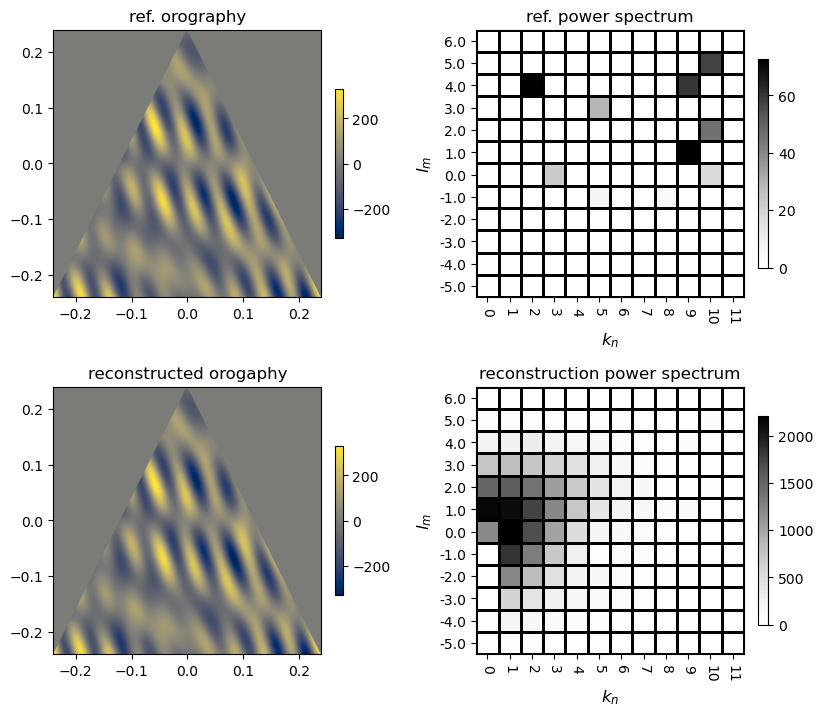

[72.54933625 72.03739344 59.87266307 57.34133141 45.85460672 28.90634369
 22.71354816 18.11068143  6.11579367  3.77039117]
[2204.39970491 2154.55857143 2112.94198779 1840.10885301 1744.05429977
 1675.28512289 1552.22093421 1498.12786621 1370.42049971 1293.76792291
 1221.28855349 1214.94335043 1205.17726343 1044.79047536 1020.67931467
  831.25060744  804.24270988  749.93416188  746.69992381  730.05597654
  716.25457549  706.67772216  615.72597358  596.82074093  507.52413795]


In [14]:
vid = utils.isoceles(grid, cell)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

cell.gen_mgrids()

cell.topo = np.cos(1.0 * cell.lat_grid) + np.sin(5.0 * cell.lon_grid)# + np.pi
cell.topo[...] = 0.0

def sinusoidal_basis(Ak, nk, Al, nl, sc, typ):        
    if sc == 0:
        bf = Ak * np.cos(nk * cell.lon_grid + nl * cell.lat_grid)
    else:
        bf = Ak * np.sin(nk * cell.lon_grid + nl * cell.lat_grid)
    
    return bf

for ii in range(sz):
    cell.topo += sinusoidal_basis(Ak[ii], nk[ii], Al[ii], nl[ii], sck[ii], 'k')

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle, mask=cell.mask)

nhi = 12
nhj = 12
fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)
a_m, data_recons = lin_reg.do(fobj, cell, lmbda=0.0)

fobj.get_freq_grid(a_m)
freqs = np.abs(fobj.ampls)

dat_2D = reconstruction.recon_2D(data_recons, cell)

fs = (10,8.5)
fig, axs = plt.subplots(2,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0,0] = fig_obj.phys_panel(axs[0,0], cell.topo * cell.mask, title="ref. orography")
axs[0,1] = fig_obj.freq_panel(axs[0,1], freqs_ref, title="ref. power spectrum")
axs[1,0] = fig_obj.phys_panel(axs[1,0], dat_2D, title="reconstructed orogaphy")
axs[1,1] = fig_obj.freq_panel(axs[1,1], freqs, title="reconstruction power spectrum")
plt.show()

dat_2D_no_reg = np.copy(dat_2D)
freqs_no_reg = np.copy(freqs)

print(np.sort(Ak)[::-1])
print(np.sort(freqs.ravel())[::-1][:25])
no_reg_sum = freqs.sum()
no_reg_err = np.linalg.norm(freqs - freqs_ref)

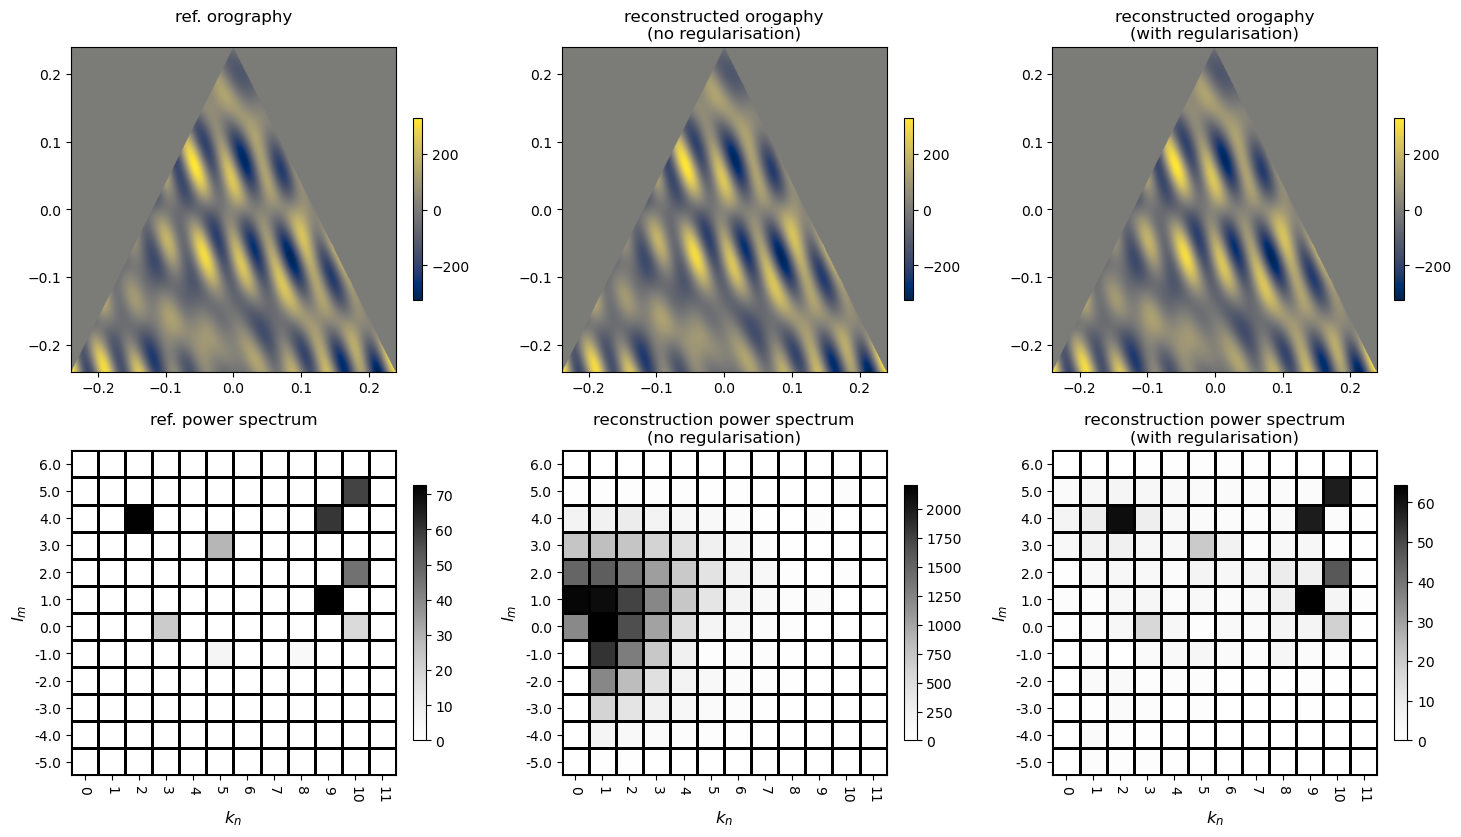

[72.54933625 72.03739344 59.87266307 57.34133141 45.85460672 28.90634369
 22.71354816 18.11068143  6.11579367  3.77039117]
[64.34479893 61.43040194 58.22699087 58.04599615 46.63780772 20.49152203
 18.57525245 16.35947083  9.64704789  9.45377734  8.68518381  8.24197157
  8.07769554  7.85681527  7.10907466  7.06682133  6.21496493  6.1529532
  5.90616667  5.5765919   5.53651311  5.32676363  5.22722005  5.04481128
  4.99015341]


In [15]:
# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle, mask=cell.mask)

nhi = 12
nhj = 12
fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)
a_m, data_recons = lin_reg.do(fobj, cell, lmbda=1e-6)

fobj.get_freq_grid(a_m)
freqs = np.abs(fobj.ampls)

dat_2D = reconstruction.recon_2D(data_recons, cell)

# fs = (10,5)
# fig, axs = plt.subplots(1,2, figsize=fs)
# fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# # axs[0,0] = fig_obj.phys_panel(axs[0,0], cell.topo * cell.mask)
# axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
# axs[1] = fig_obj.freq_panel(axs[1], freqs)
# plt.show()

fs = (15,8.5)
fig, axs = plt.subplots(2,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0,0] = fig_obj.phys_panel(axs[0,0], cell.topo * cell.mask, title="ref. orography\n")
axs[1,0] = fig_obj.freq_panel(axs[1,0], freqs_ref, title="ref. power spectrum\n")

axs[0,1] = fig_obj.phys_panel(axs[0,1], dat_2D_no_reg, title="reconstructed orogaphy\n(no regularisation)")
axs[1,1] = fig_obj.freq_panel(axs[1,1], freqs_no_reg, title="reconstruction power spectrum\n(no regularisation)")

axs[0,2] = fig_obj.phys_panel(axs[0,2], dat_2D, title="reconstructed orogaphy\n(with regularisation)")
axs[1,2] = fig_obj.freq_panel(axs[1,2], freqs, title="reconstruction power spectrum\n(with regularisation)")
plt.tight_layout()
plt.savefig('output/regularisation.pdf')
plt.show()

print(np.sort(Ak)[::-1])
print(np.sort(freqs.ravel())[::-1][:25])
single_reg_sum = freqs.sum()
single_reg_err = np.linalg.norm(freqs - freqs_ref)

Now, if we do regularisation and select the $(k,l)$-pairs with largest amplitudes...

In [16]:
nhi = 12
nhj = 12
# fobj = fourier.f_trans(nhi,nhj)

# print(fobj.pick_kls)
# fobj.do_full(cell)

# coeffs = lin_reg.get_coeffs(fobj)
# print(coeffs.shape)
# gen_am = np.random.random(coeffs.shape[1])

# ncos = 144-5
# gen_am[...] = 0.0
# gen_am = a_m
# gen_am[12] = -1.0
# gen_am[1] = 1.0
# gen_am[r_entries] = r_ampl

# data_recons_orig = coeffs.dot(gen_am)
# print(coeffs[:,1])

fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)
am_orig, data_recons_orig = lin_reg.do(fobj, cell, lmbda=0.5)

dat_2D_orig = reconstruction.recon_2D(data_recons_orig, cell)

fobj.get_freq_grid(am_orig)
freqs = np.abs(fobj.ampls)

# cell.topo_m = dat_2D_orig[cell.mask]

############

# a_m, data_recons = lin_reg.do(fobj, cell)
# dat_2D = reconstruction.recon_2D(data_recons, cell)

# fobj.get_freq_grid(a_m)
# freqs = np.abs(fobj.ampls)

############

fq_cpy = np.copy(freqs)

indices = []
for _ in range(25):
    max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
    indices.append(max_idx)
    fq_cpy[max_idx] = 0.0

k_idxs = [pair[1] for pair in indices]
l_idxs = [pair[0] for pair in indices]

# fobj.set_kls([0,1,5,4,9,3,1],[1,0,3,6,7,7,9])
# fobj.set_kls([0,1],[1,0])
fobj_2 = fourier.f_trans(nhi,nhj)
fobj_2.set_kls(k_idxs, l_idxs, recompute_nhij = False)
fobj_2.do_full(cell)

am, data_recons = lin_reg.do(fobj_2, cell, lmbda = 1e-6)

fobj_2.get_freq_grid(am)
dat_2D = reconstruction.recon_2D(data_recons, cell)

freqs = np.abs(fobj_2.ampls)

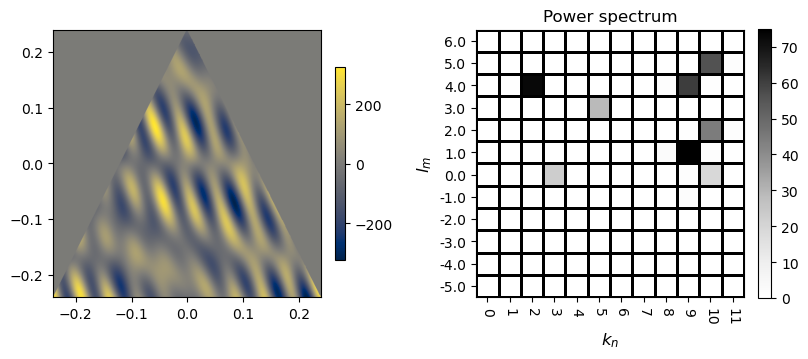

[72.54933625 72.03739344 59.87266307 57.34133141 45.85460672 28.90634369
 22.71354816 18.11068143  6.11579367  3.77039117]
[75.01245485 72.85324616 60.486003   56.19677689 44.38354269 28.78974687
 22.67378462 19.16746288  2.60190904  2.05387129  1.69175326  1.5047937
  1.31895489  1.22293882  1.2227075   0.92722028  0.86214602  0.78619957
  0.565033    0.52458482  0.42651386  0.40555444  0.31854385  0.19674128
  0.10412437]


In [17]:
cl_range = np.arange(0,1.0)
fl_range = np.arange(1,19,1)/10.0

coarse_lmbdas = np.zeros((nhi,nhj,len(cl_range)))
# coarse_lmbdas = np.zeros((nhi*nhj,len(cl_range)))
fine_lmbdas = np.zeros_like((nhi,nhj,len(fl_range)))

coarse_lmbdas_errs = np.zeros_like(coarse_lmbdas)
fine_lmbdas_errs = np.zeros_like(fine_lmbdas)

# cnt = 0
# for li,ln in enumerate(ll):
#     for ki,kn in enumerate(kk):
#         # print(kn,ln)
#         if ((kn == 0) and (ln < 0)):
#             coarse_lmbdas[li,ki,...] = 0.0
#             # coarse_lmbdas[cnt,...] = 0.0

#         coarse_lmbdas[li,ki,...] = li+ki #10.0#np.abs(kn)+np.abs(ln)
        # coarse_lmbdas[cnt,...] = kn+ln
        
        
# coarse_lmbdas = coarse_lmbdas.reshape(nhi,nhj,len(cl_range))
# coarse_lmbdas = np.transpose(coarse_lmbdas,axes=(1,0,2))
projected = np.zeros((nhi,nhj))

# for li,ln in enumerate(ll):
#     for ki,kn in enumerate(kk):
#         if ((kn == 0) and (ln < 0)):
#             continue
            
#         projected[li,ki] = coarse_lmbdas[li,ki,0]
        
projected = projected.reshape(nhi,nhj)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()

print(np.sort(Ak)[::-1])
print(np.sort(freqs.ravel())[::-1][:25])
double_reg_sum = freqs.sum()
double_reg_err = np.linalg.norm(freqs - freqs_ref)

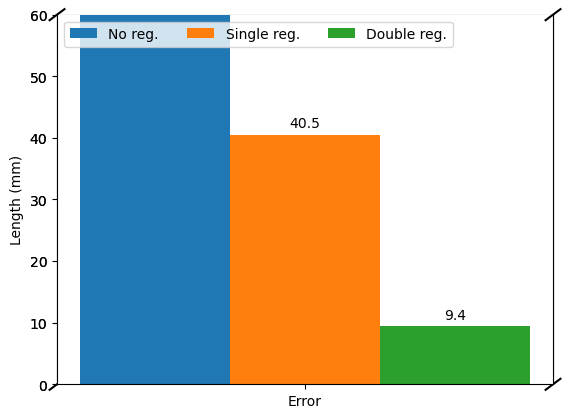

In [33]:
import matplotlib.pyplot as plt
import numpy as np

categories = ("Error",)
runs = {
    # 'Reference': (0.0),
    'No reg.': (np.around(no_reg_err,1)),
    'Single reg.': (np.around(single_reg_err,1)),
    'Double reg.': (np.around(double_reg_err,1)),
}

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(constrained_layout=True)
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
fig.subplots_adjust(hspace=-1.0)

for name, value in runs.items():
    if name == 'No reg.':
        value = no_reg_err
    offset = width * multiplier
    rects = ax1.bar(x + offset, value, width, label=name)
    rects = ax2.bar(x + offset, value, width, label=name)
    ax1.bar_label(rects, padding=3)
    ax2.bar_label(rects, padding=3)
    multiplier += 1
    
ax1.set_ylim(6500., 6700.)  # outliers only
ax2.set_ylim(0., 60.)  # most of the data

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labelbottom=False, tick1On=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)



# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Length (mm)')
# ax.set_title('')
ax2.set_xticks(x + width, categories)
ax2.legend(loc='upper left', ncol=3)
# ax.grid()
# ax.set_ylim(0, 250)

plt.show()

# category = ("Error", "Total power")
# runs = {
#     'Reference': (0.0, ref_sum, 14.98),
#     'No reg.': (no_reg_err, no_reg_sum, 47.50),
#     'Single reg.': (single_reg_err, single_reg_sum, 217.19),
#     'Double reg.': (double_reg_err, double_reg_sum, 217.19),
# }

# x = np.arange(len(species))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(constrained_layout=True)

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncol=4)
# # ax.grid()
# ax.set_ylim(0, 250)

# plt.show()

In [22]:

print(fa.icons['thumbs-up'])




errs = [6693.97, 40.55, 9.35]


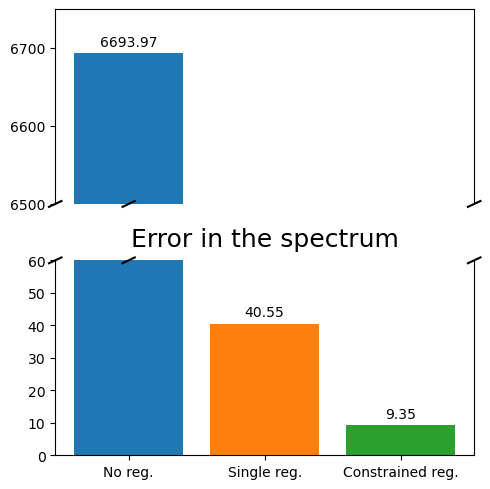

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fontawesome as fa

XX = pd.Series([np.around(no_reg_err,2),np.around(single_reg_err,2),np.around(double_reg_err,2)],index=['No reg.','Single reg.','Constrained reg.'])
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,
                         figsize=(5,5))
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)


print("errs =", [np.around(no_reg_err,2),np.around(single_reg_err,2),np.around(double_reg_err,2)])
bs = 60
ts = 6500

ax2.set_ylim(0,bs)
ax1.set_ylim(ts,6750)
ax1.set_yticks(np.arange(6500,6700+100,100))

bars1 = ax1.bar(XX.index, XX.values, color=('C0'))
bars2 = ax2.bar(XX.index, XX.values, color=('C0', 'C1', 'C2', 'r'))
ax1.bar_label(bars1, padding=3)
ax2.bar_label(bars2, padding=3)

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)
d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

for b1, b2 in zip(bars1, bars2):
    posx = b2.get_x() + b2.get_width()/2.
    if b2.get_height() > bs:
        ax2.plot((posx-3*d, posx+3*d), (1 - d, 1 + d), color='k', clip_on=False,
                 transform=ax2.get_xaxis_transform())
    if b1.get_height() > ts:
        ax1.plot((posx-3*d, posx+3*d), (- d, + d), color='k', clip_on=False,
                 transform=ax1.get_xaxis_transform())
        
plt.title("Error in the spectrum", fontsize=18, pad=10)
plt.tight_layout()
plt.savefig('output/errors.pdf')
plt.show()

In [293]:
print(no_reg_sum)

37900.64302725344


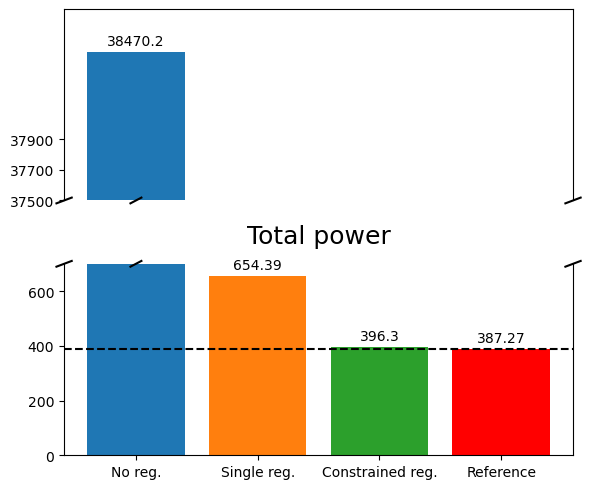

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

XX = pd.Series([np.around(no_reg_sum,2),np.around(single_reg_sum,2),np.around(double_reg_sum,2), np.around(ref_sum, 2)],index=['No reg.','Single reg.','Constrained reg.', 'Reference'])
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,
                         figsize=(6,5))
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)

bs = 700
ts = 37500

ax2.set_ylim(0,bs)
ax1.set_ylim(ts,38750)
ax1.set_yticks(np.arange(ts,38000+100,200))

bars1 = ax1.bar(XX.index, XX.values, color=('C0'))
bars2 = ax2.bar(XX.index, XX.values, color=('C0', 'C1', 'C2', 'r'))
ax1.bar_label(bars1, padding=3)
ax2.bar_label(bars2, padding=3)

ax2.axhline(np.around(ref_sum, 2), ls='--', c='k')

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)
d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

for b1, b2 in zip(bars1, bars2):
    posx = b2.get_x() + b2.get_width()/2.
    if b2.get_height() > bs:
        ax2.plot((posx-3*d, posx+3*d), (1 - d, 1 + d), color='k', clip_on=False,
                 transform=ax2.get_xaxis_transform())
    if b1.get_height() > ts:
        ax1.plot((posx-3*d, posx+3*d), (- d, + d), color='k', clip_on=False,
                 transform=ax1.get_xaxis_transform())
        
plt.title("Total power", fontsize=18, pad=15)
plt.tight_layout()
plt.savefig('output/total_power.pdf')
plt.show()

## Random test doodle cells

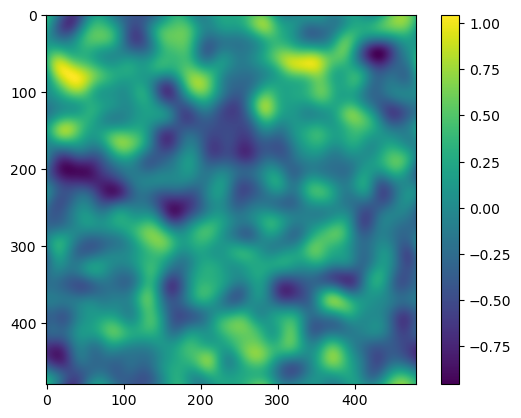

In [384]:
k = np.random.random ([480,480])


dt = 0.1
for _ in range(1000):
    kp = np.pad(k, ((1,1),(1,1)), mode='wrap')
    kll = kp[:-2,1:-1]
    krr = kp[2:,1:-1]
    ktt = kp[1:-1,2:]
    kbb = kp[1:-1,:-2]
    k = k + dt * (kll + krr + ktt + kbb - 4.0 * k)
k -= k.mean()
var = k.max() - k.min()
k /= 0.5 * var

plt.figure()
plt.imshow(k)
plt.colorbar()
plt.show()

In [166]:

ll = np.arange(-5,7)
kk = np.arange(0,12)

for kn in kk:
    for ln in ll:
        if ((kn == 0) and (ln < 0)):
            continue
        
        func = np.sin( kn * cell.lat_grid + ln * cell.lon_grid)
        print(kn, ln)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 -5
1 -4
1 -3
1 -2
1 -1
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 -5
2 -4
2 -3
2 -2
2 -1
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 -5
3 -4
3 -3
3 -2
3 -1
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 -5
4 -4
4 -3
4 -2
4 -1
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 -5
5 -4
5 -3
5 -2
5 -1
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 -5
6 -4
6 -3
6 -2
6 -1
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 -5
7 -4
7 -3
7 -2
7 -1
7 0
7 1
7 2
7 3
7 4
7 5
7 6
8 -5
8 -4
8 -3
8 -2
8 -1
8 0
8 1
8 2
8 3
8 4
8 5
8 6
9 -5
9 -4
9 -3
9 -2
9 -1
9 0
9 1
9 2
9 3
9 4
9 5
9 6
10 -5
10 -4
10 -3
10 -2
10 -1
10 0
10 1
10 2
10 3
10 4
10 5
10 6
11 -5
11 -4
11 -3
11 -2
11 -1
11 0
11 1
11 2
11 3
11 4
11 5
11 6


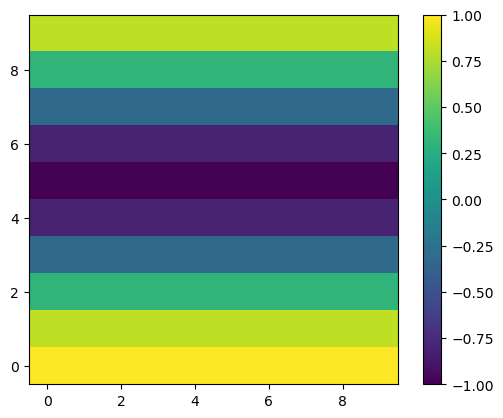

0.5


In [75]:
Nx = 10

xx = np.arange(0, 2.0 * np.pi, 2.0 * np.pi / Nx)

XX, YY = np.meshgrid(xx,xx)

ZZ = np.cos(YY)
# ZZ[np.where(ZZ < 0.0)] = 0.0

plt.figure()
plt.imshow(ZZ, origin='lower')
plt.colorbar()
plt.show()

ampls = np.fft.fft2(ZZ)

print( np.abs(ampls).max() / (Nx**2) )

In [81]:
ss = np.sort(ampls)

# print(ss)
# print(ss[::-1])

ffreqs = np.fft.fftfreq(Nx)
ffreqs = np.fft.fftshift(ffreqs)

print(ffreqs)

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]


In [73]:
np.linspace(0.0, 1.0, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

[ 1.22464680e-16+0.00000000e+00j -5.66553890e-16-5.00000000e+00j
  1.22464680e-16-2.11176968e-16j  3.11710912e-16+0.00000000e+00j
  1.22464680e-16-1.30514544e-16j  9.72791780e-17+2.22044605e-16j
  1.22464680e-16+1.30514544e-16j  1.28089482e-16+2.22044605e-16j
  1.22464680e-16+2.11176968e-16j -5.82849082e-16+5.00000000e+00j]
[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]


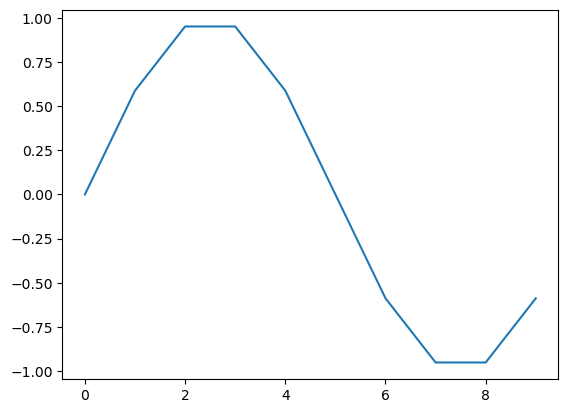

In [90]:
Nx = 10

xx = np.arange(0, 2.0 * np.pi, 2.0 * np.pi / Nx)
yy = np.sin(xx)

pwr = np.fft.fft(yy)

print(pwr)

ffreqs = np.fft.fftfreq(Nx)

print(ffreqs)

plt.figure()
plt.plot(yy)
plt.show()

In [95]:
print(pwr * np.conj(pwr))
print(np.sqrt(pwr * np.conj(pwr)))

[1.49975978e-32+0.j 2.50000000e+01+0.j 5.95933098e-32+0.j
 9.71636924e-32+0.j 3.20316441e-32+0.j 5.87670450e-32+0.j
 3.20316441e-32+0.j 6.57107221e-32+0.j 5.95933098e-32+0.j
 2.50000000e+01+0.j]
[1.22464680e-16+0.j 5.00000000e+00+0.j 2.44117410e-16+0.j
 3.11710912e-16+0.j 1.78973864e-16+0.j 2.42419152e-16+0.j
 1.78973864e-16+0.j 2.56341027e-16+0.j 2.44117410e-16+0.j
 5.00000000e+00+0.j]


In [94]:
print(np.abs(pwr))

[1.22464680e-16 5.00000000e+00 2.44117410e-16 3.11710912e-16
 1.78973864e-16 2.42419152e-16 1.78973864e-16 2.56341027e-16
 2.44117410e-16 5.00000000e+00]
